In [46]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
from noise_detection.non_ride_detection import filter_known_issues 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from tueplots import bundles
from tueplots.constants.color import rgb
from scipy.stats import mannwhitneyu
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [15]:

#load main dataframe
# load matching data frame
# merge the matcher.merge (main_df[idx, city], left_on = "d_idx", rignt_on = "idx")

In [22]:
# Load matching candidates
matching_df = pd.read_parquet('/Users/francescatubaro/Desktop/Wintersemester1/Data Literacy/escooter-tracker/matching_candidates_scored.parquet')
print(f"Matching candidates shape: {matching_df.shape}")
matching_df.head()


Matching candidates shape: (45278301, 25)


,d_idx,f_idx,provider,vehicle_type_id,d_lat,d_lon,f_lat,f_lon,d_time,f_time,...,opt_route_min,speed,log_p_distance,log_p_speed,log_p_range,score,prob_forward,prob_backward,prob_null,prob
0,171071,173445,bolt_basel,BLT:VehicleType:e92dc79f-736d-5eca-9ff4-180665...,47.559498,7.598561,47.537254,7.570603,2025-10-26 14:10:06.891088,2025-10-26 14:27:06.883382,...,12.000000,12.988334,-2.502355,-2.203296,-1.685448,-6.391099,9.997973e-01,9.154952e-01,0.000203,9.153096e-01
1,171713,177179,bolt_basel,BLT:VehicleType:e92dc79f-736d-5eca-9ff4-180665...,47.578182,7.589325,47.513931,7.620455,2025-10-26 14:15:06.910183,2025-10-26 14:52:06.898922,...,27.299999,13.783854,-4.937281,-2.163429,-5.086204,-12.186913,9.350702e-04,4.159073e-02,0.001164,3.889026e-05
2,171713,173443,bolt_basel,BLT:VehicleType:e92dc79f-736d-5eca-9ff4-180665...,47.578182,7.589325,47.563847,7.591785,2025-10-26 14:15:06.910183,2025-10-26 14:27:06.883382,...,7.000000,10.600394,-1.496594,-2.633249,-32.344440,-36.474281,6.174466e-19,3.588094e-07,0.001164,2.215457e-25
3,171713,180306,bolt_basel,BLT:VehicleType:e92dc79f-736d-5eca-9ff4-180665...,47.578182,7.589325,47.552078,7.621399,2025-10-26 14:15:06.910183,2025-10-26 15:13:06.871626,...,17.200001,5.493165,-3.434094,-5.115246,-13.601135,-22.150475,7.360793e-10,4.914604e-04,0.001164,3.617538e-13
4,171713,174099,bolt_basel,BLT:VehicleType:e92dc79f-736d-5eca-9ff4-180665...,47.578182,7.589325,47.563206,7.588843,2025-10-26 14:15:06.910183,2025-10-26 14:32:06.902328,...,6.200000,6.564756,-1.327730,-4.417964,-3.411419,-9.157114,4.014666e-01,9.999986e-01,0.001164,4.014661e-01


In [23]:
# Load vehicle events (only city column needed, use index for joining)
events_df = pd.read_parquet('../vehicle_events_export.parquet', columns=['city'])
events_df['idx'] = events_df.index
print(f"Vehicle events shape: {events_df.shape}")
events_df.head()

Vehicle events shape: (16476198, 2)


,city,idx
0,Stuttgart,0
1,Stuttgart,1
2,Stuttgart,2
3,Stuttgart,3
4,Stuttgart,4


In [24]:
# Join city column to matching data based on d_idx = idx (event index)
matching_with_city = matching_df.merge(
    events_df,
    left_on='d_idx',
    right_on='idx',
    how='left'
).drop(columns=['idx'])

print(f"Matching with city shape: {matching_with_city.shape}")
print(f"\nCity distribution:")
print(matching_with_city['city'].value_counts(dropna= False))

Matching with city shape: (45278301, 26)

City distribution:
city
Stuttgart                 17576237
Zürich                     8455697
Karlsruhe                  8132132
Saarbrücken                4034049
Mannheim                   2507886
Reutlingen/Tübingen         782223
Heilbronn                   767975
Bern                        541625
Basel                       541456
Ulm                         490300
Mainz                       450629
Kaiserslautern              269714
Pforzheim                   228702
Heidelberg                  144157
St. Gallen                  118575
Friedrichshafen              81403
Villingen-Schwenningen       57490
Freiburg                     53607
Konstanz                     16627
Winterthur                   10029
Überlingen                    8237
Lindau                        6533
Bregenz                       3018
Name: count, dtype: int64


In [25]:
# Filter out known data quality issues (Saarbrücken 3am spike)
matching_filtered = filter_known_issues(matching_with_city)
print(f"\nFiltered city distribution:")
print(matching_filtered['city'].value_counts(dropna=False))

Filtered out 359,950 trips (0.8%):
  - Saarbrücken 3am: 359,950

Filtered city distribution:
city
Stuttgart                 17576237
Zürich                     8455697
Karlsruhe                  8132132
Saarbrücken                3674099
Mannheim                   2507886
Reutlingen/Tübingen         782223
Heilbronn                   767975
Bern                        541625
Basel                       541456
Ulm                         490300
Mainz                       450629
Kaiserslautern              269714
Pforzheim                   228702
Heidelberg                  144157
St. Gallen                  118575
Friedrichshafen              81403
Villingen-Schwenningen       57490
Freiburg                     53607
Konstanz                     16627
Winterthur                   10029
Überlingen                    8237
Lindau                        6533
Bregenz                       3018
Name: count, dtype: int64


# TEMPORAL ANALYSIS

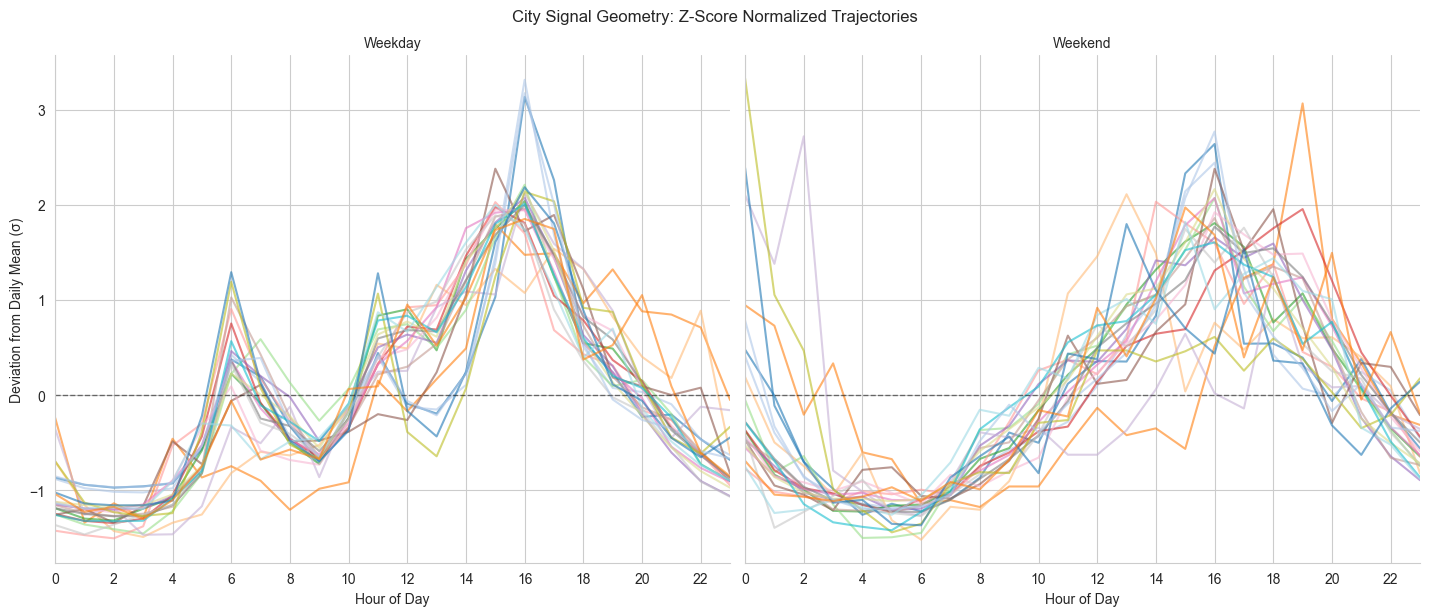

In [42]:
#usage pattern across hours of day and weekdays/weekends
matching_filtered['d_time'] = pd.to_datetime(matching_filtered['d_time'])
matching_filtered['hour'] = matching_filtered['d_time'].dt.hour
matching_filtered['day_of_week'] = matching_filtered['d_time'].dt.dayofweek
matching_filtered['day_type'] = matching_filtered['day_of_week'].apply(
    lambda x: 'Weekend' if x >= 5 else 'Weekday'
)

df = matching_filtered.groupby(['city', 'day_type', 'hour']).size().reset_index(name='count')

#z-normalization across hours within each city and day type
df['mean'] = df.groupby(['city', 'day_type'])['count'].transform('mean')
df['std']  = df.groupby(['city', 'day_type'])['count'].transform('std')
df['z_score'] = (df['count'] - df['mean']) / df['std']


g = sns.relplot(
    data=df,
    x="hour",
    y="z_score",
    hue="city",       
    col="day_type",   
    kind="line",
    height=6,
    aspect=1.2,
    estimator=None,   
    lw=1.5,
    alpha=0.6,        
    palette="tab20",  
    legend=False      
)

g.fig.suptitle("City Signal Geometry: Z-Score Normalized Trajectories", y=1.02)
g.set_axis_labels("Hour of Day", "Deviation from Daily Mean (σ)")
g.set_titles("{col_name}")
g.set(xlim=(0, 23), xticks=range(0, 24, 2))

for ax in g.axes.flat:
    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)

plt.show()

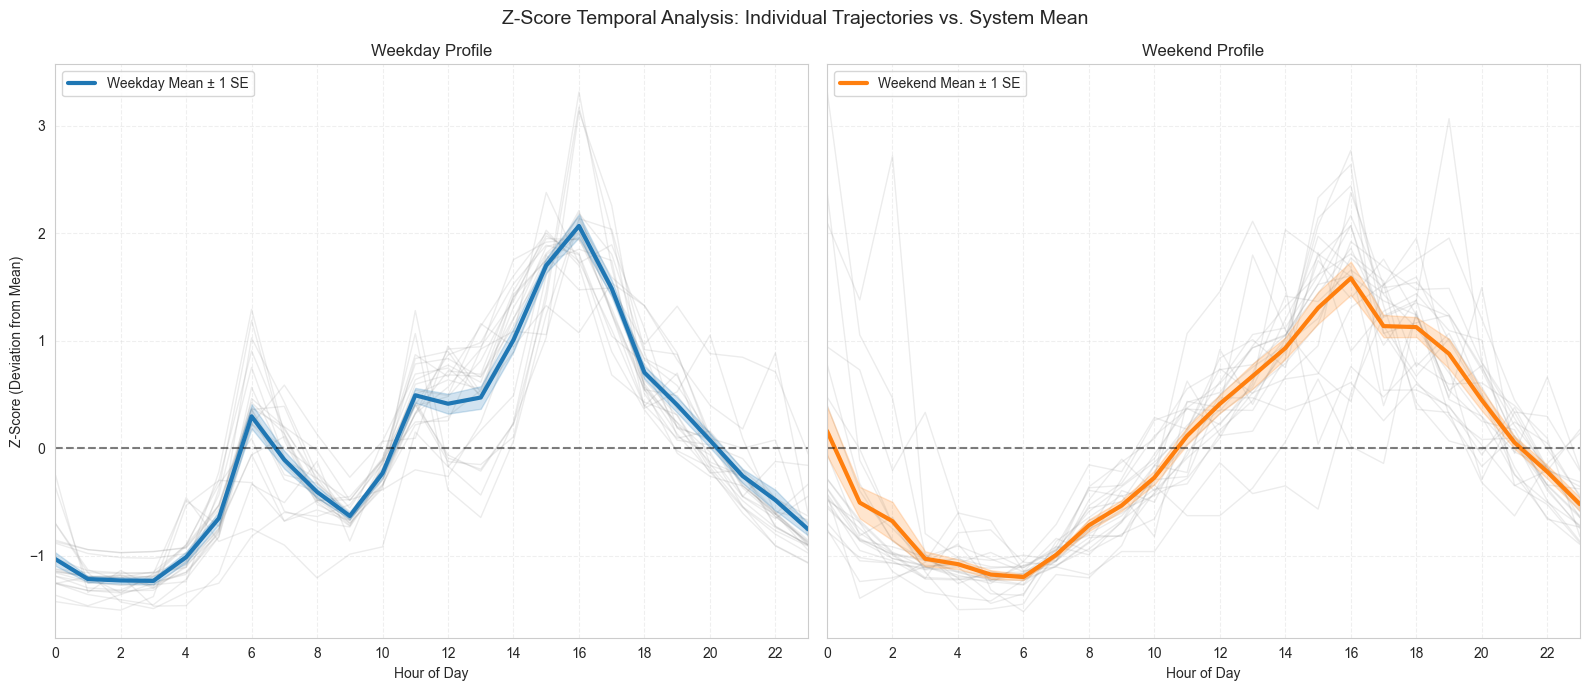

In [43]:
# system average with confidence intervals vs individual trajectories
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

for i, dtype in enumerate(['Weekday', 'Weekend']):
    subset = df[df['day_type'] == dtype]
    ax = axes[i]
    
   # LAYER A: Individual City Trajectories
    sns.lineplot(
        data=subset,
        x="hour",
        y="z_score",
        units="city",
        estimator=None,
        color="grey",
        alpha=0.15,      
        lw=1,
        ax=ax,
        zorder=1
    )
    
    # LAYER B: The Model (Mean + Standard Error)
    sns.lineplot(
        data=subset,
        x="hour",
        y="z_score",
        color="tab:blue" if dtype == 'Weekday' else "tab:orange",
        lw=3,
        errorbar=('se', 1),  
        ax=ax,
        label=f"{dtype} Mean ± 1 SE",
        zorder=2
    )
    
    
    ax.set_title(f"{dtype} Profile")
    ax.set_xlabel("Hour of Day")
    if i == 0: ax.set_ylabel("Z-Score (Deviation from Mean)")
    ax.set_xlim(0, 23)
    ax.set_xticks(range(0, 24, 2))
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.axhline(0, color='black', linestyle='--', alpha=0.5) 
    ax.legend(loc='upper left')

plt.suptitle("Z-Score Temporal Analysis: Individual Trajectories vs. System Mean", fontsize=14)
plt.tight_layout()
plt.show()

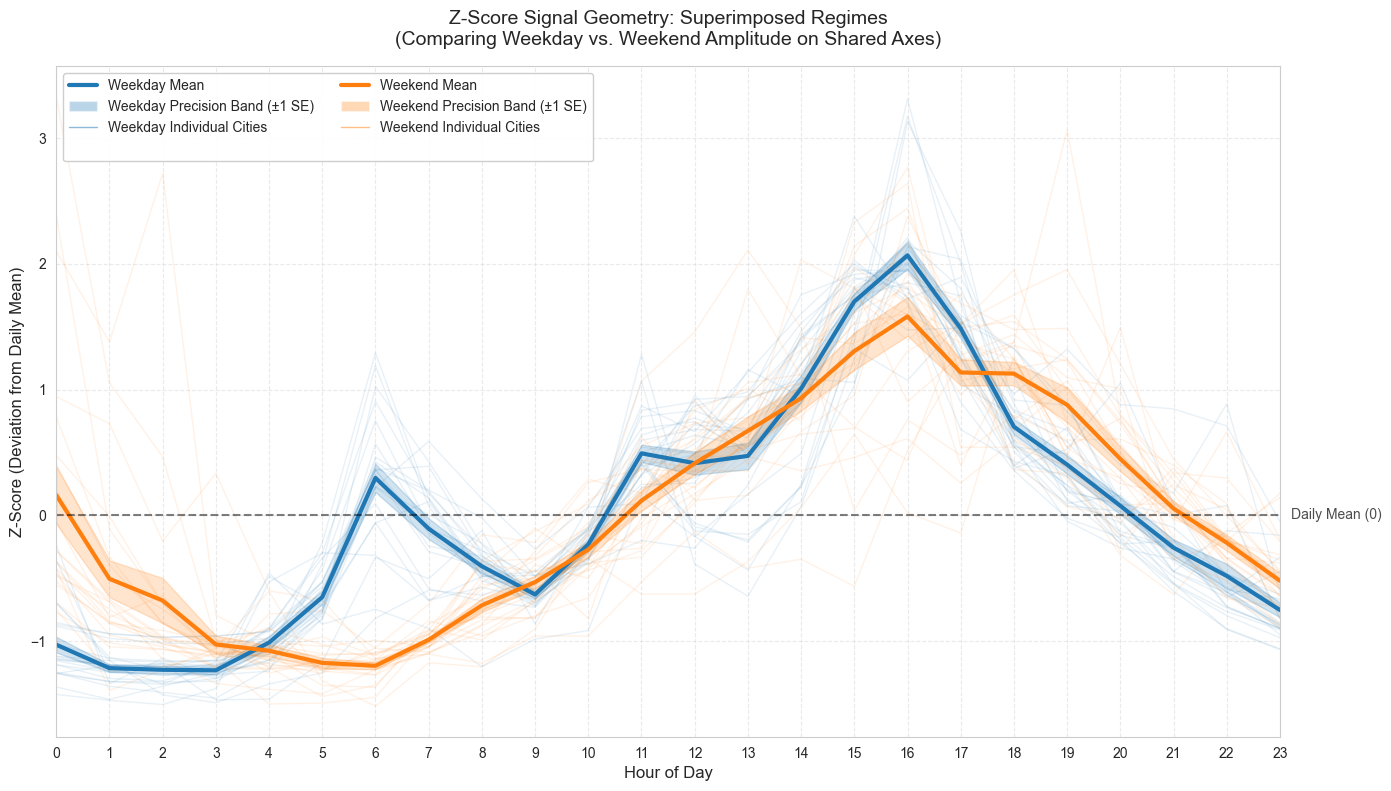

In [66]:
#comparing visually the patterns between weekdays and weekends

plt.figure(figsize=(14, 8))

regimes = [
    ('Weekday', 'tab:blue', 'lightblue'),
    ('Weekend', 'tab:orange', 'navajowhite')
]

for name, main_color, bg_color in regimes:
    subset = df[df['day_type'] == name]
    
    sns.lineplot(
        data=subset,
        x="hour",
        y="z_score",
        units="city",
        estimator=None,   
        color=main_color, 
        alpha=0.1,        
        lw=1,
        zorder=1,         
        legend=False
    )

    sns.lineplot(
        data=subset,
        x="hour",
        y="z_score",
        color=main_color,
        lw=3,
        errorbar=('se', 1), 
        label=f"{name} Mean ± 1 SE",
        zorder=2          
    )

legend_elements = [
    Line2D([0], [0], color='tab:blue', lw=3, label='Weekday Mean'),
    Patch(facecolor='tab:blue', alpha=0.3, label='Weekday Precision Band (±1 SE)'),
    Line2D([0], [0], color='tab:blue', lw=1, alpha=0.5, label='Weekday Individual Cities'),
    
    Line2D([0], [0], color='white', label=''), 

    Line2D([0], [0], color='tab:orange', lw=3, label='Weekend Mean'),
    Patch(facecolor='tab:orange', alpha=0.3, label='Weekend Precision Band (±1 SE)'),
    Line2D([0], [0], color='tab:orange', lw=1, alpha=0.5, label='Weekend Individual Cities'),
]
plt.legend(handles=legend_elements, loc='upper left', ncol=2, frameon=True, framealpha=0.95)

plt.title("Z-Score Signal Geometry: Superimposed Regimes\n(Comparing Weekday vs. Weekend Amplitude on Shared Axes)", fontsize=14, y=1.02)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Z-Score (Deviation from Daily Mean)", fontsize=12)
plt.xlim(0, 23)
plt.xticks(range(0, 24))

plt.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5, label='Daily Mean (0)')
plt.text(23.2, 0, 'Daily Mean (0)', va='center', fontsize=10, color='black', alpha=0.7)

plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

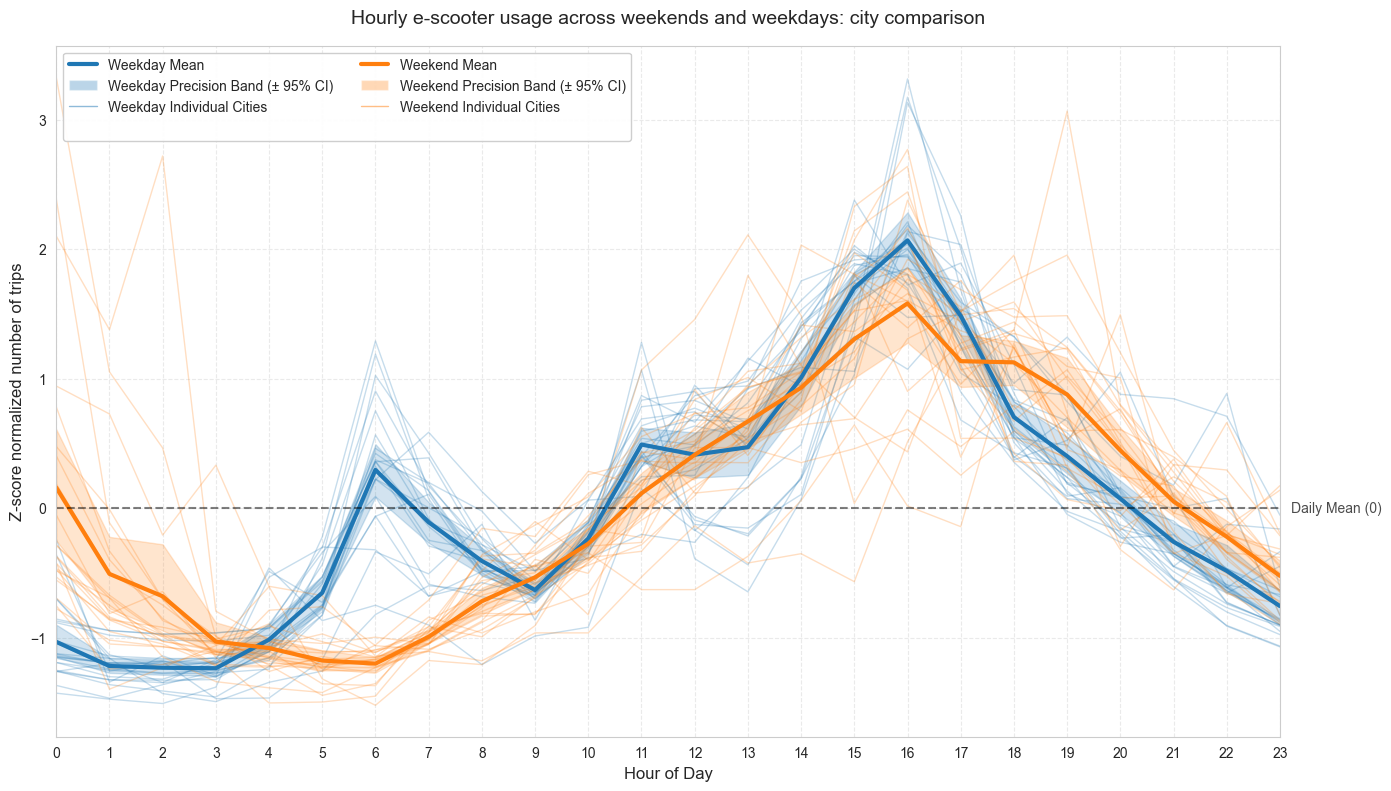

In [65]:
#comparing visually the patterns between weekdays and weekends

plt.figure(figsize=(14, 8))

regimes = [
    ('Weekday', 'tab:blue', 'lightblue'),
    ('Weekend', 'tab:orange', 'navajowhite')
]

for name, main_color, bg_color in regimes:
    subset = df[df['day_type'] == name]
    
    sns.lineplot(
        data=subset,
        x="hour",
        y="z_score",
        units="city",
        estimator=None,   
        color=main_color, 
        alpha=0.25,        
        lw=1,
        zorder=1,         
        legend=False
    )

    sns.lineplot(
        data=subset,
        x="hour",
        y="z_score",
        color=main_color,
        lw=3,
        errorbar=('ci', 95), 
        label=f"{name} Mean ± 95% CI",
        zorder=2          
    )

legend_elements = [
    Line2D([0], [0], color='tab:blue', lw=3, label='Weekday Mean'),
    Patch(facecolor='tab:blue', alpha=0.3, label='Weekday Precision Band (± 95% CI)'),
    Line2D([0], [0], color='tab:blue', lw=1, alpha=0.5, label='Weekday Individual Cities'),
    
    Line2D([0], [0], color='white', label=''), 

    Line2D([0], [0], color='tab:orange', lw=3, label='Weekend Mean'),
    Patch(facecolor='tab:orange', alpha=0.3, label='Weekend Precision Band (± 95% CI)'),
    Line2D([0], [0], color='tab:orange', lw=1, alpha=0.5, label='Weekend Individual Cities'),
]
plt.legend(handles=legend_elements, loc='upper left', ncol=2, frameon=True, framealpha=0.95)

plt.title("Hourly e-scooter usage across weekends and weekdays: city comparison", fontsize=14, y=1.02)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Z-score normalized number of trips", fontsize=12)
plt.xlim(0, 23)
plt.xticks(range(0, 24))

plt.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5, label='Daily Mean (0)')
plt.text(23.2, 0, 'Daily Mean (0)', va='center', fontsize=10, color='black', alpha=0.7)

plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

In [59]:

# 1. Calculate the Hourly Summary (The "Fleet Baseline")
# ---------------------------------------------------------
# N is the number of cities (used for SE calculation)
num_cities = df['city'].nunique()

hourly_summary = df.groupby(['day_type', 'hour']).agg(
    fleet_mean=('count', 'mean'),
    fleet_sd=('count', 'std')
).reset_index()

# Calculate Standard Error (SE) and Coefficient of Variation (CV)
# CV = SD / Mean (Shows relative "chaos" regardless of city size)
hourly_summary['fleet_se'] = hourly_summary['fleet_sd'] / np.sqrt(num_cities)
hourly_summary['variability_index'] = hourly_summary['fleet_sd'] / hourly_summary['fleet_mean']

# 2. Identify the "Geometry Outliers"
# ---------------------------------------------------------
# Find the city with the highest and lowest Z-score for each hour
top_outliers = df.sort_values(['day_type', 'hour', 'z_score_cross_city']).groupby(['day_type', 'hour']).tail(1)
bot_outliers = df.sort_values(['day_type', 'hour', 'z_score_cross_city']).groupby(['day_type', 'hour']).head(1)

# Merge for a clean report
outliers_report = top_outliers[['day_type', 'hour', 'city', 'z_score_cross_city']].rename(
    columns={'city': 'max_outlier_city', 'z_score_cross_city': 'max_z'}
).merge(
    bot_outliers[['day_type', 'hour', 'city', 'z_score_cross_city']].rename(
        columns={'city': 'min_outlier_city', 'z_score_cross_city': 'min_z'}
    ), on=['day_type', 'hour']
)

# Export to CSV for your records
print(hourly_summary.head())
outliers_report.head()


  day_type  hour   fleet_mean      fleet_sd     fleet_se  variability_index
0  Weekday     0  5661.130435  10622.567064  2214.958347           1.876404
1  Weekday     1  2333.086957   4216.048893   879.106964           1.807069
2  Weekday     2  1503.227273   2598.667001   541.859527           1.728725
3  Weekday     3  2136.136364   3648.936796   760.855918           1.708195
4  Weekday     4  9240.391304  17189.754390  3584.311564           1.860284


,day_type,hour,max_outlier_city,max_z,min_outlier_city,min_z
0,Weekday,0,Zürich,3.272078,Lindau,-0.531240
1,Weekday,1,Zürich,2.838893,Bregenz,-0.551010
2,Weekday,2,Stuttgart,3.099579,Lindau,-0.575767
3,Weekday,3,Stuttgart,2.948493,Winterthur,-0.582399
4,Weekday,4,Stuttgart,3.575072,Winterthur,-0.536156


In [63]:
# 1. Aggregation: Calculate Mean, SD, and Count per hour
dispersion = (
    df.groupby(["day_type", "hour"])["z_score"]
    .agg(
        mean="mean",
        std="std",
        count="count"
    )
    .reset_index()
)

# 2. Calculate Engineering Metrics
# Standard Error (Precision of the Mean)
dispersion["se"] = dispersion["std"] / np.sqrt(dispersion["count"])

# 95% Confidence Interval (Margin of Error)
dispersion["ci_95"] = 1.96 * dispersion["se"]

# Define the "System Envelope" (The variability range of individual cities)
dispersion["envelope_upper"] = dispersion["mean"] + dispersion["std"]
dispersion["envelope_lower"] = dispersion["mean"] - dispersion["std"]

# Display the first few rows
print(dispersion.head(10))

  day_type  hour      mean       std  count        se     ci_95  \
0  Weekday     0 -1.028534  0.299679     23  0.062487  0.122475   
1  Weekday     1 -1.215190  0.138995     23  0.028982  0.056806   
2  Weekday     2 -1.228259  0.138145     22  0.029453  0.057727   
3  Weekday     3 -1.232198  0.144368     22  0.030779  0.060328   
4  Weekday     4 -1.011791  0.249710     23  0.052068  0.102054   
5  Weekday     5 -0.650306  0.263521     23  0.054948  0.107698   
6  Weekday     6  0.297398  0.541699     23  0.112952  0.221386   
7  Weekday     7 -0.106397  0.395710     23  0.082511  0.161722   
8  Weekday     8 -0.405145  0.259048     23  0.054015  0.105870   
9  Weekday     9 -0.628863  0.146069     23  0.030457  0.059697   

   envelope_upper  envelope_lower  
0       -0.728854       -1.328213  
1       -1.076195       -1.354185  
2       -1.090114       -1.366404  
3       -1.087830       -1.376566  
4       -0.762081       -1.261501  
5       -0.386785       -0.913827  
6        0

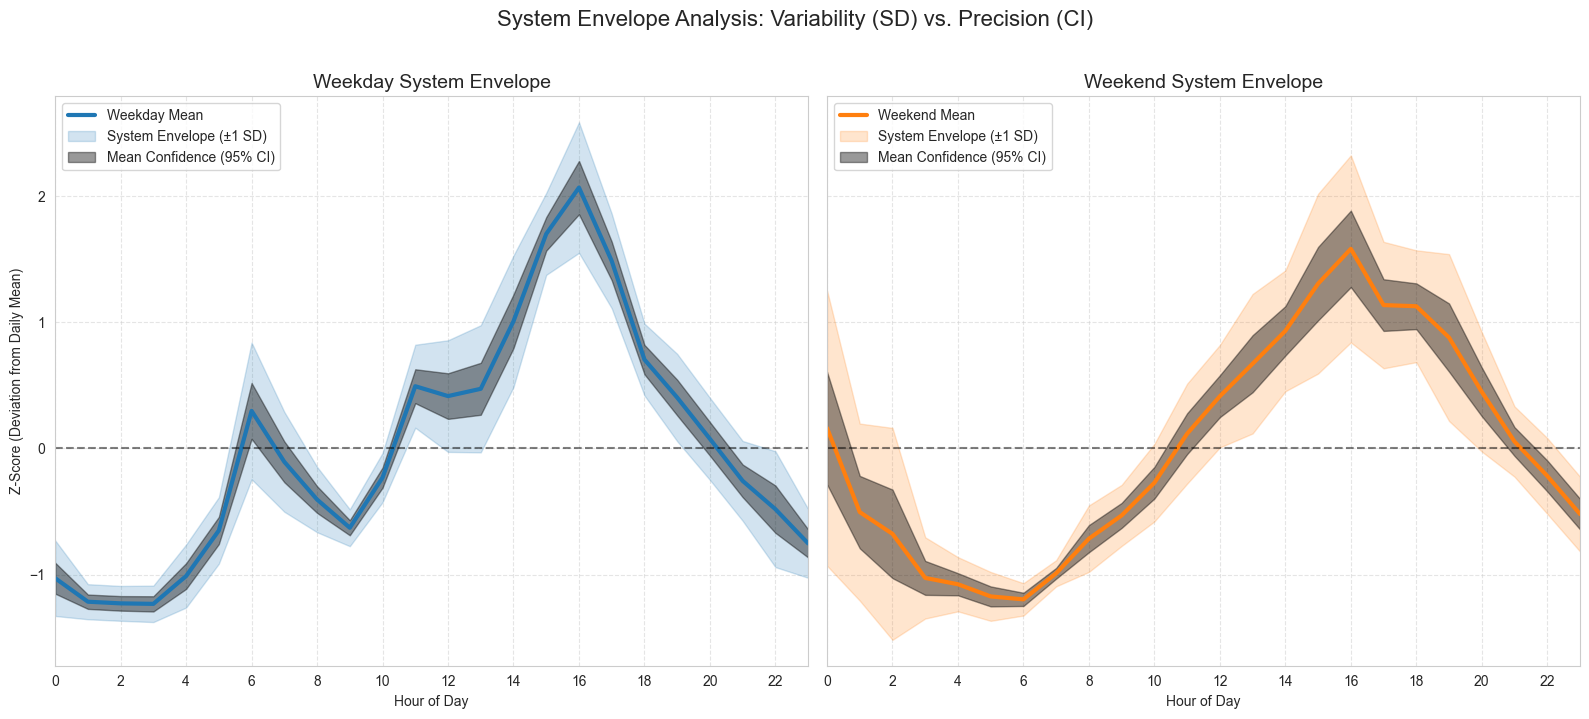

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

for i, dtype in enumerate(['Weekday', 'Weekend']):
    # Filter data for this regime
    subset = dispersion[dispersion['day_type'] == dtype]
    ax = axes[i]
    color = 'tab:blue' if dtype == 'Weekday' else 'tab:orange'
    
    # 1. Plot the Mean (The "Target" Line)
    ax.plot(
        subset['hour'], 
        subset['mean'], 
        color=color, 
        lw=3, 
        label=f'{dtype} Mean'
    )
    
    # 2. Plot the System Envelope (Mean ± SD)
    # This represents the "Normal Operating Range" for individual cities
    ax.fill_between(
        subset['hour'],
        subset['envelope_lower'],
        subset['envelope_upper'],
        color=color,
        alpha=0.2,
        label=f'System Envelope (±1 SD)'
    )
    
    # 3. Plot the Confidence Interval (Mean ± 95% CI)
    # This represents the precision of the mean line itself (much narrower)
    ax.fill_between(
        subset['hour'],
        subset['mean'] - subset['ci_95'],
        subset['mean'] + subset['ci_95'],
        color='black',
        alpha=0.4,
        label='Mean Confidence (95% CI)'
    )

    # Styling
    ax.set_title(f"{dtype} System Envelope", fontsize=14)
    ax.set_xlabel("Hour of Day")
    ax.set_xlim(0, 23)
    ax.set_xticks(range(0, 24, 2))
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.axhline(0, color='black', linestyle='--', alpha=0.5)
    
    # Legend
    ax.legend(loc='upper left')

axes[0].set_ylabel("Z-Score (Deviation from Daily Mean)")
plt.suptitle("System Envelope Analysis: Variability (SD) vs. Precision (CI)", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()